In [19]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_order
from statsmodels.regression.linear_model import OLS
import numpy as np
import warnings
import itertools

# screen for liquidity
# screen for vol within industry
# screen for market cap mid-large cap

warnings.filterwarnings("ignore", category=UserWarning)

class portfolio_result:
    def __init__(self):
        self.trace = 0
        self.result_90 = 0
        self.result_95 = 0
        self.result_99 = 0
        self.eigen_weight = 0
    def display(self):
        print("Trace Statistics:", [self.trace])
        print("Critical Values (90%, 95%, 99%):", [self.result_90, self.result_95, self.result_99])
        print("Weights:", self.eigen_weight)

def calculate_half_life(y):
    y_lagged = np.roll(y, 1)
    y_lagged[0] = 0
    delta_y = y - y_lagged
    delta_y = delta_y[1:]
    y_lagged = y_lagged[1:]
    X = np.column_stack([y_lagged, np.ones(len(y_lagged))])
    regression_result = OLS(delta_y, X).fit()
    gamma = regression_result.params[0]
    half_life = -np.log(2) / gamma  
    return half_life

def get_price_data(data, ticker, start_date, end_date):      
    price_series = yf.download(ticker, start=start_date, end=end_date)[['Close']].rename(columns={"Close":ticker})
    data = pd.concat([data, price_series], axis=1)
    return data

def find_best_cointegration(data, test_stats, conf_intervals, eig):
    passing_rates = []
    for i in range(len(test_stats)):
        passing_rate = sum(test_stats[i] > conf_intervals[i])
        passing_rates.append(passing_rate)
    max_passing_rate = max(passing_rates)
    max_indices = [i for i, rate in enumerate(passing_rates) if rate == max_passing_rate]
    if len(max_indices) > 1:
        half_lives = []
        for indices in max_indices:
            half_lives.append(calculate_half_life( np.dot(data.values, eig[indices])))
        best_index = min(max_indices, key=lambda i: half_lives[i])
    else:
        best_index = max_indices[0]
    return best_index

def perform_johansen(data):
    try:
        lag_order = select_order(data, maxlags=10, deterministic='n')
        johansen_result = coint_johansen(data.values, det_order=0, k_ar_diff=lag_order.aic)
        index = find_best_cointegration(data, johansen_result.lr1, johansen_result.cvt, johansen_result.evec)   
        result = portfolio_result()
        result.trace = johansen_result.lr1[index]
        result.result_90 = johansen_result.cvt[index][0]
        result.result_95 = johansen_result.cvt[index][1]
        result.result_99 = johansen_result.cvt[index][2]
        result.eigen_weight = johansen_result.evec[index]
        return result
    except:
        return 0

def calculate_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate / 252
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    return sharpe_ratio * np.sqrt(252)  # Annualize the Sharpe ratio

def get_stock_info(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info
    return {
        'ticker': ticker,
        'marketCap': info.get('marketCap'),
        'averageVolume': info.get('averageVolume')
    }

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url, header=0)
    sp500_df = table[0]
    return sp500_df

def get_mid_large_cap_stocks(min_market_cap=2e8, min_avg_volume=1e6):
    sp500_tickers = get_sp500_tickers()['Symbol'].tolist()
    stock_data = []
    for ticker in sp500_tickers:
        info = get_stock_info(ticker)
        if info['marketCap'] and info['averageVolume']:
            if info['marketCap'] >= min_market_cap and info['averageVolume'] >= min_avg_volume:
                stock_data.append(info)
    return pd.DataFrame(stock_data)

def select_random_stocks(n=5):
    stock_df = get_mid_large_cap_stocks()
    return stock_df.sample(n=n)['ticker'].tolist()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Testing combination: ('KMX', 'HRL')
Testing combination: ('KMX', 'TXT')
Testing combination: ('KMX', 'AMZN')
Testing combination: ('KMX', 'FE')
Testing combination: ('HRL', 'TXT')
Testing combination: ('HRL', 'AMZN')
Testing combination: ('HRL', 'FE')
Testing combination: ('TXT', 'AMZN')
Testing combination: ('TXT', 'FE')
Testing combination: ('AMZN', 'FE')
Testing combination: ('KMX', 'HRL', 'TXT')
Testing combination: ('KMX', 'HRL', 'AMZN')
Testing combination: ('KMX', 'HRL', 'FE')
Testing combination: ('KMX', 'TXT', 'AMZN')
Testing combination: ('KMX', 'TXT', 'FE')
Testing combination: ('KMX', 'AMZN', 'FE')
Testing combination: ('HRL', 'TXT', 'AMZN')
Testing combination: ('HRL', 'TXT', 'FE')
Testing combination: ('HRL', 'AMZN', 'FE')
Testing combination: ('TXT', 'AMZN', 'FE')
Testing combination: ('KMX', 'HRL', 'TXT', 'AMZN')
Testing combination: ('KMX', 'HRL', 'TXT', 'FE')
Testing combination: ('KMX', 'HRL', 'AMZN', 'FE')
Testing combination: ('KMX', 'TXT', 'AMZN', 'FE')
Testing co

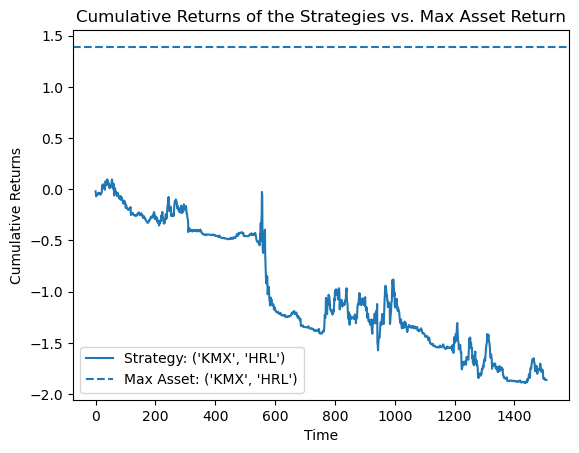

Combination: ('KMX', 'TXT'), Sharpe Ratio: 0.09601314319167531, Max Cumulative Return of an Asset: 1.3911365193869285


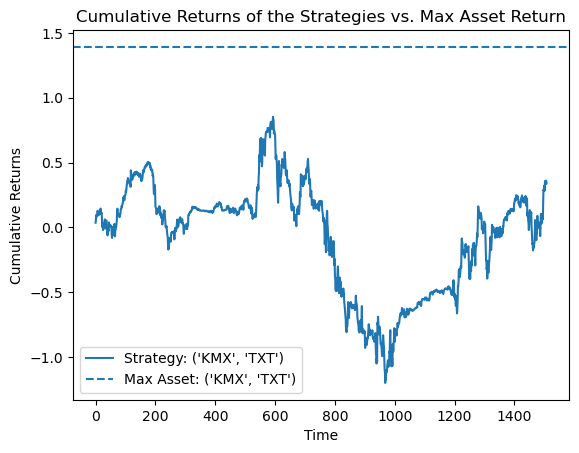

Combination: ('KMX', 'AMZN'), Sharpe Ratio: 0.9792465801914522, Max Cumulative Return of an Asset: 2.138249368350495


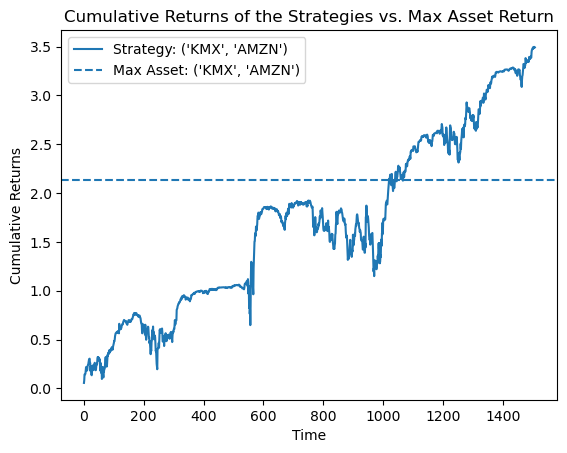

Combination: ('KMX', 'FE'), Sharpe Ratio: 0.6185173067929818, Max Cumulative Return of an Asset: 1.3911365193869285


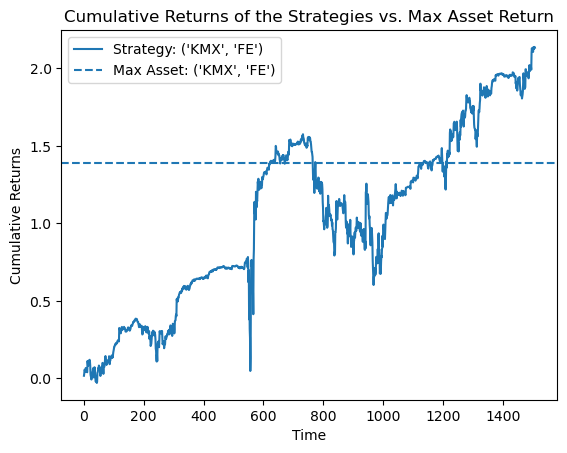

Combination: ('HRL', 'TXT'), Sharpe Ratio: 0.668248923893537, Max Cumulative Return of an Asset: 0.5074257550393704


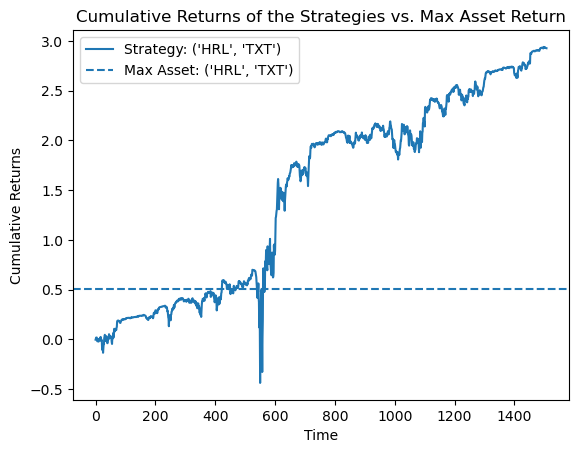

Combination: ('HRL', 'AMZN'), Sharpe Ratio: 0.8832832148733795, Max Cumulative Return of an Asset: 2.138249368350495


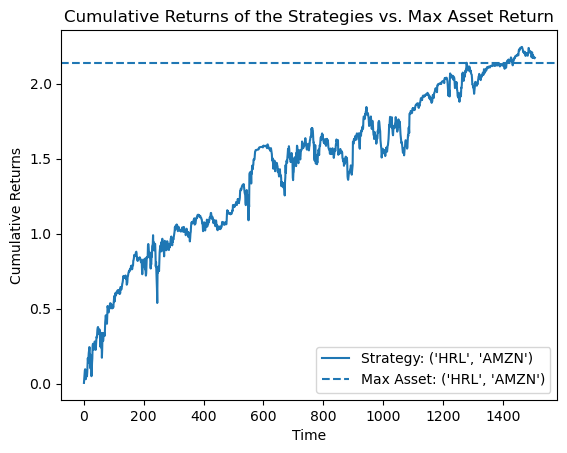

Combination: ('HRL', 'FE'), Sharpe Ratio: 0.39817607370518193, Max Cumulative Return of an Asset: 0.6959766701925558


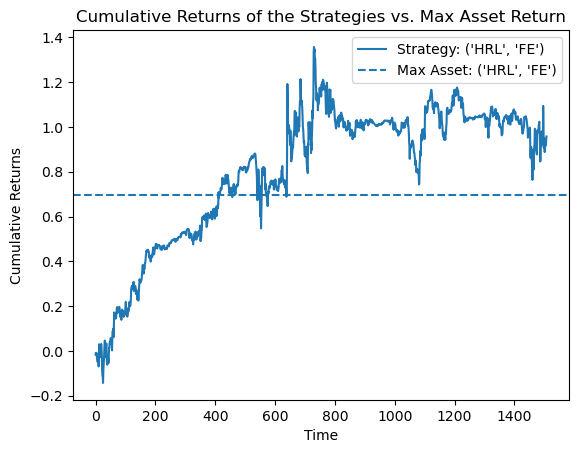

Combination: ('TXT', 'AMZN'), Sharpe Ratio: 0.43638071522372024, Max Cumulative Return of an Asset: 2.138249368350495


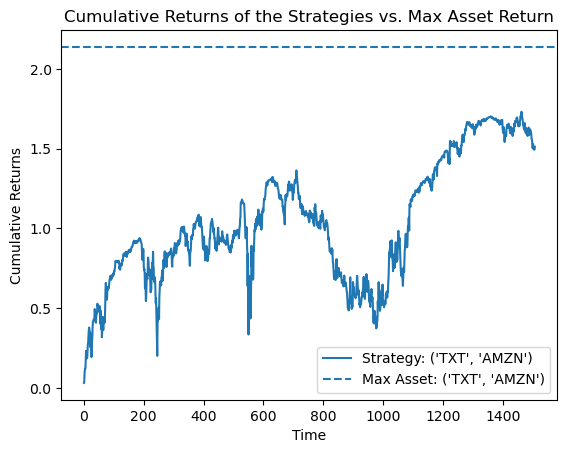

Combination: ('TXT', 'FE'), Sharpe Ratio: 1.4196680746992814, Max Cumulative Return of an Asset: 0.6959766701925558


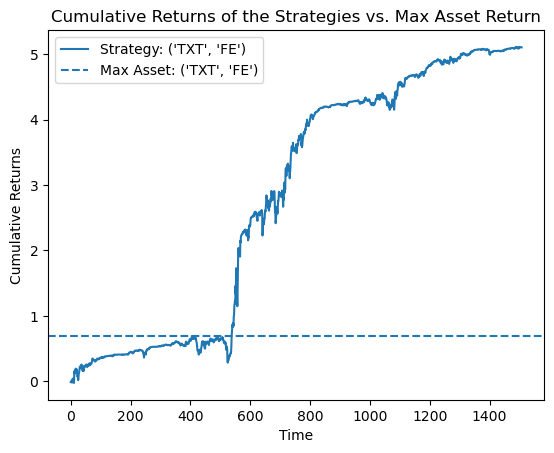

Combination: ('AMZN', 'FE'), Sharpe Ratio: 1.0484988854504078, Max Cumulative Return of an Asset: 2.138249368350495


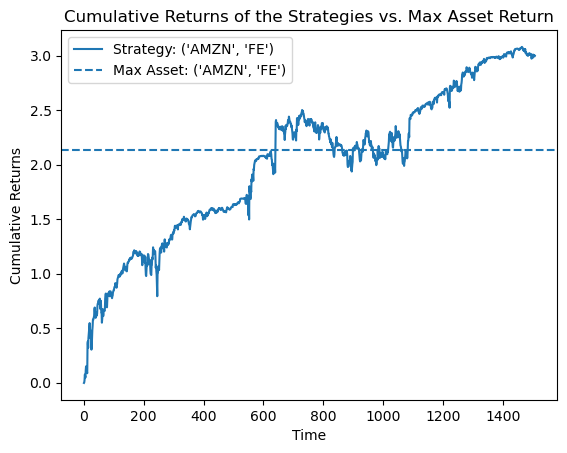

Combination: ('KMX', 'HRL', 'TXT'), Sharpe Ratio: -0.5757731265262986, Max Cumulative Return of an Asset: 1.3911365193869285


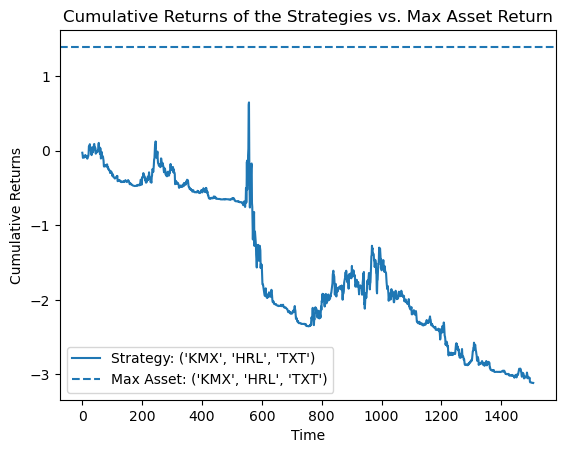

Combination: ('KMX', 'HRL', 'AMZN'), Sharpe Ratio: 0.13571052612681245, Max Cumulative Return of an Asset: 2.138249368350495


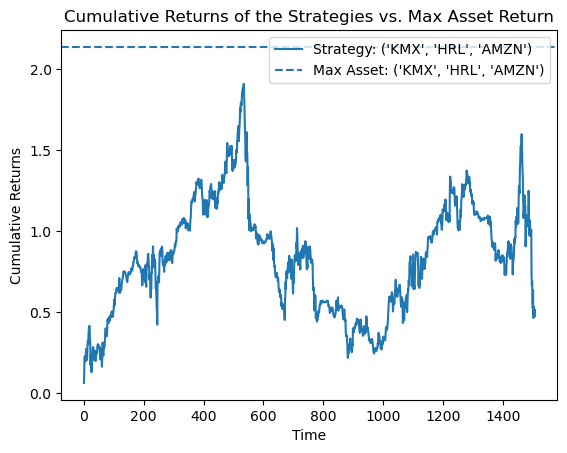

Combination: ('KMX', 'HRL', 'FE'), Sharpe Ratio: 0.07276198083404134, Max Cumulative Return of an Asset: 1.3911365193869285


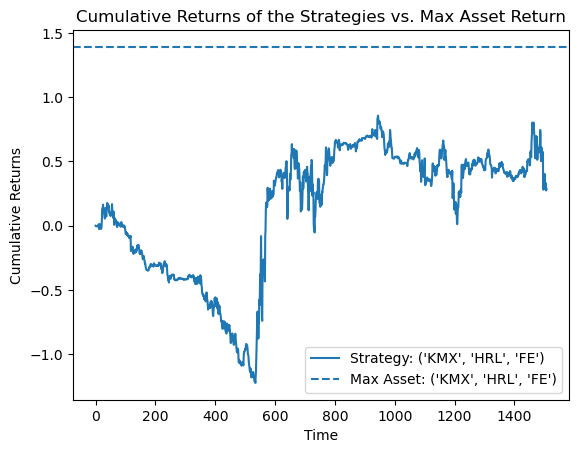

Combination: ('KMX', 'TXT', 'AMZN'), Sharpe Ratio: 0.8199739165486507, Max Cumulative Return of an Asset: 2.138249368350495


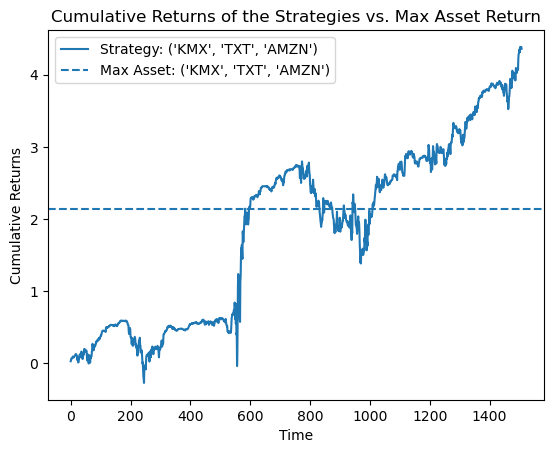

Combination: ('KMX', 'TXT', 'FE'), Sharpe Ratio: -0.7780910125291312, Max Cumulative Return of an Asset: 1.3911365193869285


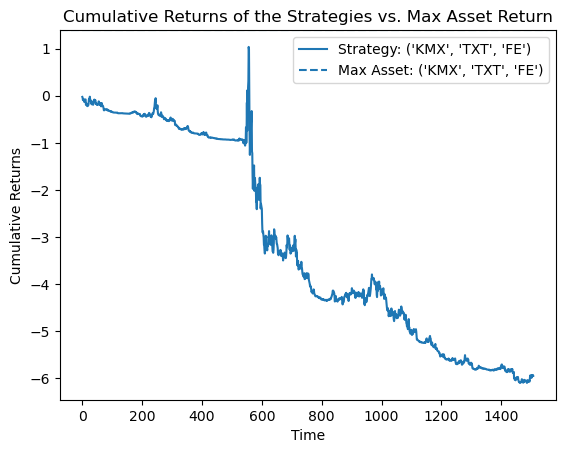

Combination: ('KMX', 'AMZN', 'FE'), Sharpe Ratio: -0.1695475100720775, Max Cumulative Return of an Asset: 2.138249368350495


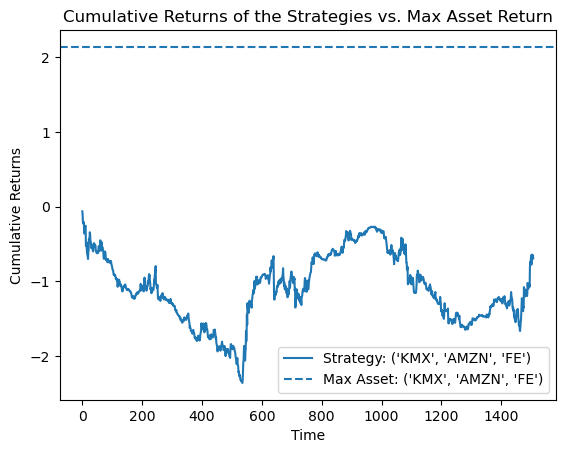

Combination: ('HRL', 'TXT', 'AMZN'), Sharpe Ratio: 0.17678642921537038, Max Cumulative Return of an Asset: 2.138249368350495


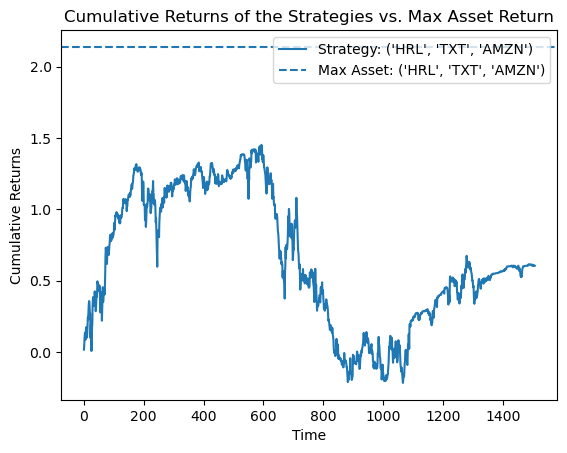

Combination: ('HRL', 'TXT', 'FE'), Sharpe Ratio: 0.5885963626324128, Max Cumulative Return of an Asset: 0.6959766701925558


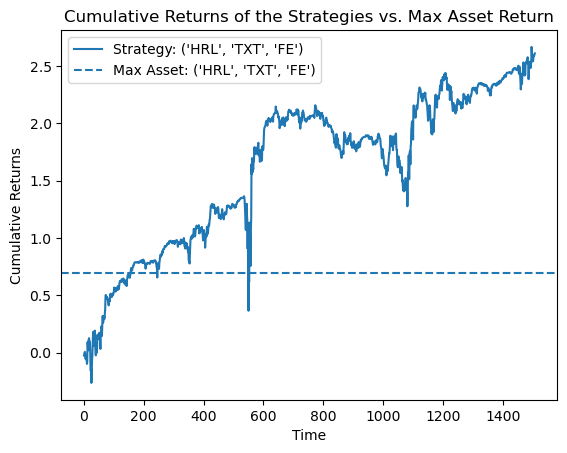

Combination: ('HRL', 'AMZN', 'FE'), Sharpe Ratio: -0.9780637351136447, Max Cumulative Return of an Asset: 2.138249368350495


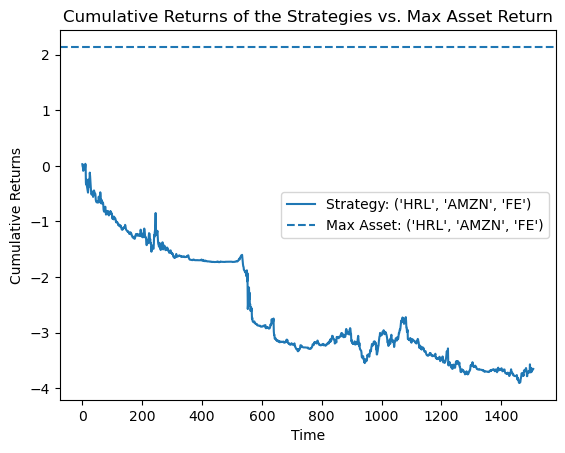

Combination: ('TXT', 'AMZN', 'FE'), Sharpe Ratio: 0.36336746536977477, Max Cumulative Return of an Asset: 2.138249368350495


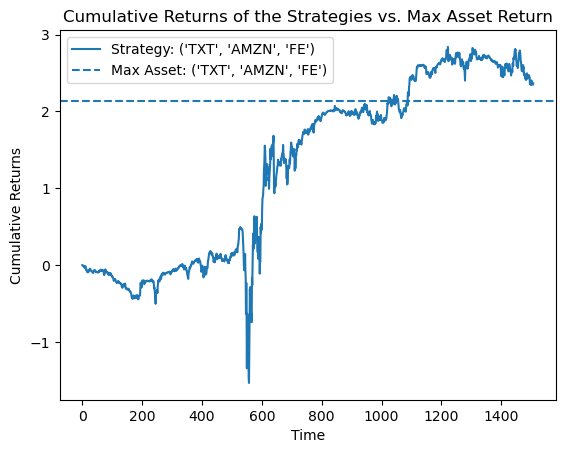

Combination: ('KMX', 'HRL', 'TXT', 'AMZN'), Sharpe Ratio: 0.9212753862954731, Max Cumulative Return of an Asset: 2.138249368350495


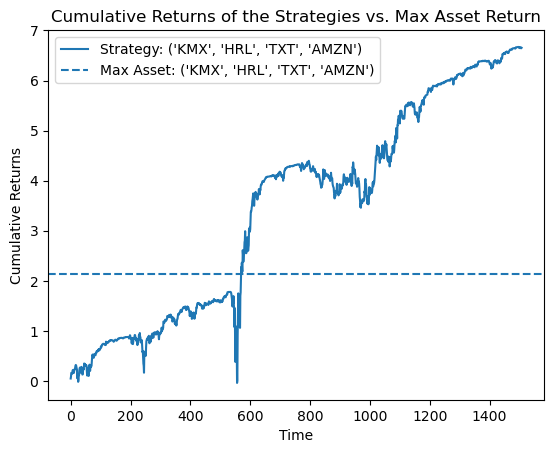

Combination: ('KMX', 'HRL', 'TXT', 'FE'), Sharpe Ratio: -0.3804583836084245, Max Cumulative Return of an Asset: 1.3911365193869285


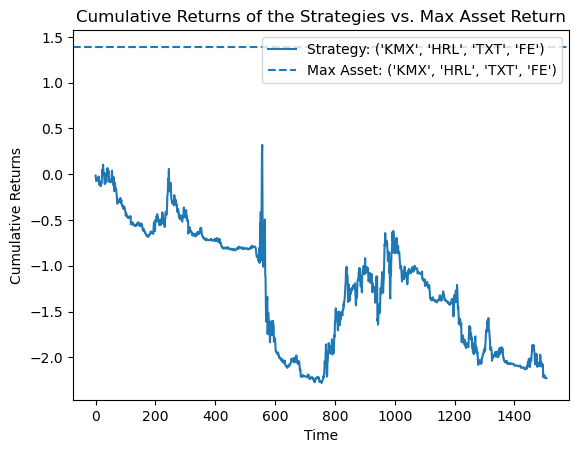

Combination: ('KMX', 'HRL', 'AMZN', 'FE'), Sharpe Ratio: 0.6172123728405196, Max Cumulative Return of an Asset: 2.138249368350495


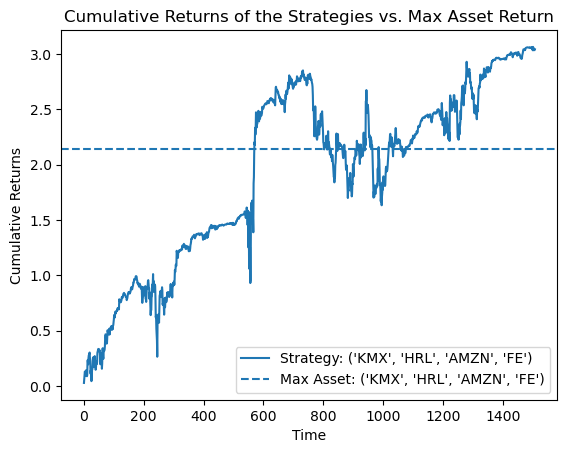

Combination: ('KMX', 'TXT', 'AMZN', 'FE'), Sharpe Ratio: -0.6761106209597962, Max Cumulative Return of an Asset: 2.138249368350495


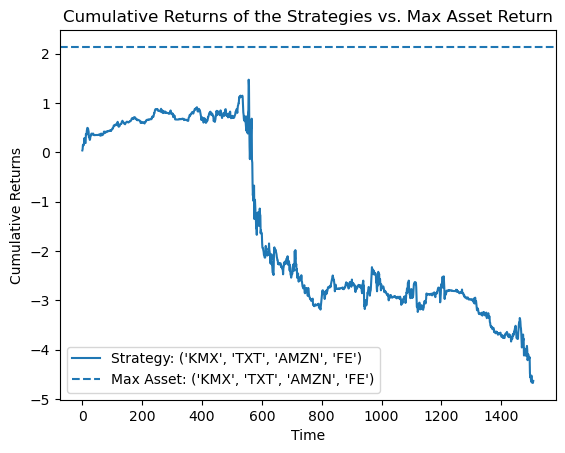

Combination: ('HRL', 'TXT', 'AMZN', 'FE'), Sharpe Ratio: 0.856008934332815, Max Cumulative Return of an Asset: 2.138249368350495


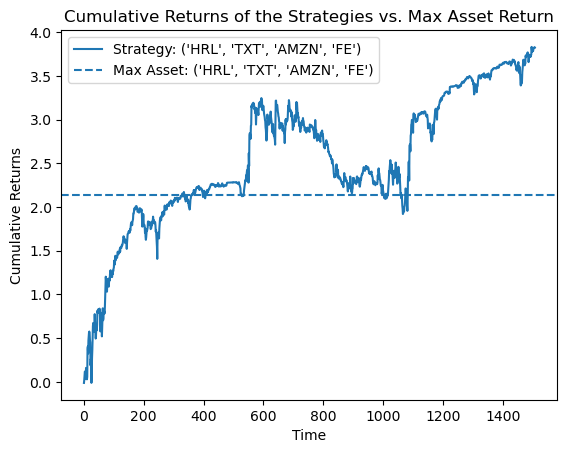

Combination: ('KMX', 'HRL', 'TXT', 'AMZN', 'FE'), Sharpe Ratio: 0.344798136292615, Max Cumulative Return of an Asset: 2.138249368350495


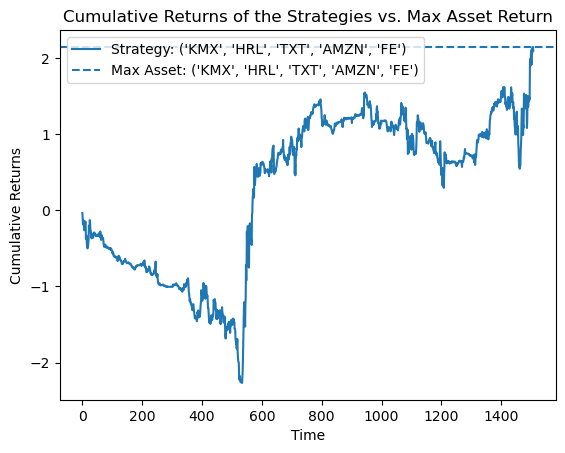

In [23]:
import matplotlib.pyplot as plt

start_date = "2018-01-01"
end_date = "2024-01-01"
tickers = select_random_stocks(n=5)
# Store the results
all_data = pd.DataFrame([])
for ticker in tickers:
    all_data = get_price_data(all_data, ticker, start_date, end_date)

results = []
for i in range(2,len(tickers)+1):
    ticker_combinations = list(itertools.combinations(tickers, i))
    for combo in ticker_combinations:
        data = all_data[list(combo)]
        print(f"Testing combination: {combo}")
        result = perform_johansen(data)
        if result == 0:
            print("Combination failed to converge.\n")
            continue
        cointegrated_portfolio = np.dot(data.values, result.eigen_weight)
        z_score = (cointegrated_portfolio - np.mean(cointegrated_portfolio)) / np.std(cointegrated_portfolio)
        position_size = -z_score    
        returns = data.pct_change().dropna()   
        strategy_returns = (returns.values * position_size[:-1, np.newaxis]).sum(axis=1)   
        sharpe_ratio = calculate_sharpe_ratio(strategy_returns)   
        cumulative_returns_strategy = np.cumsum(strategy_returns)    
        cumulative_returns_assets = (1 + returns).cumprod() - 1    
        max_cumulative_return = cumulative_returns_assets.max().max()
        results.append({
            'combo': combo,
            'sharpe_ratio': sharpe_ratio,
            'cumulative_returns_strategy': cumulative_returns_strategy,
            'cointegrated_portfolio': cointegrated_portfolio,
            'max_cumulative_return_asset': max_cumulative_return
        })
# add SnP returns and sharpe.
for result in results:
    print(f"Combination: {result['combo']}, Sharpe Ratio: {result['sharpe_ratio']}, Max Cumulative Return of an Asset: {result['max_cumulative_return_asset']}")
    plt.plot(result['cumulative_returns_strategy'], label=f"Strategy: {result['combo']}")
    plt.axhline(result['max_cumulative_return_asset'], linestyle='--', label=f"Max Asset: {result['combo']}")
    plt.title('Cumulative Returns of the Strategies vs. Max Asset Return')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()